# Deep Learning for Computer Vision:  HW 2


## Computer Science: COMS W 4995 004


## Due: October 13, 2020

#### Problem

You are given the noisy XOR data generated for you below. Your task is to implement a multi-layer perceptron binary classifier with one hidden layer. For the activiation function of the hidden units use ReLu. For the loss function use a softplus on a linear output layer as we did in class.

a) Implement each layer of the network as a separate function with both forward propagation and backpropagation. 

b) Train the network using stochastic gradient descent with mini-batches.  

c) Show the decision regions of the trained classifier by densely generating points in the plane and color coding these points with the binary labels. 

d) Repeat (b) and (c) varying the number of hidden units: 3, 16, 512. Discuss how the number of hidden units effects the solution.

e) Try choosing your own loss function (without asking me or the TAs what you should choose), repeating (d).

f) Now try with three inputs, generating your own training and validation data. (For this XOR the output should be a 1 if and only if exactly one of the inputs is 1. But make the training data noisy as before.) Use softplus loss. Do not try to show the decision regions, instead generate a validation set in the same manner as the training set, classify the samples, and compute the classification accuracy.

g) Using your data from HW1 or any new data you curate, train your MLP using your training set (80%). Compute the error rate on your validation set (20%). It's up to you how many hidden units to use. 

If you are struggling to get the network to converge, experiment with different learning rates.

Grading: a-d = 65%, e=10%, f=5%, g=20%. 

#### NOTE:  Do not to use keras, tensorflow, pytorch, sklearn, etc. to do this.  You must build the machine learning components from scratch.



Let's start by importing some libraries.

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

Let's make up some noisy XOR data.

In [2]:
# Give 0 or 1 label using XOR operation for either two or three features input
def label_XOR(x_arr):
    if len(x_arr) == 2:
        return 1.0 * np.logical_xor(x_arr[0] == 1.0, x_arr[1] == 1.0)
    
    elif len(x_arr) == 3:
        if x_arr[0] == 0.0:
            return 1.0 * np.logical_xor(x_arr[1] == 1.0, x_arr[2] == 1.0)
        
        elif x_arr[1] == 0.0:
            return 1.0 * np.logical_xor(x_arr[0] == 1.0, x_arr[2] == 1.0)
        
        elif x_arr[2] == 0.0:
            return 1.0 * np.logical_xor(x_arr[0] == 1.0, x_arr[1] == 1.0)
        
    return 0.0

# Add random normal noise
def add_noise(x, coeff):
    return x + coeff * np.random.normal()

# Build an XOR dataset, with arbitrary number of data and features
def build_data(n_data, n_features):
    columns = []
    
    for i in range(0, n_features):
        columns.append('x' + str(i+1))
        
    columns.append('y')
    
    data = pd.DataFrame(np.zeros((n_data, n_features + 1)), columns=columns)
    
    x_arr = np.zeros(n_features)

    # Let's make up some noisy XOR data to use to build our binary classifier
    for i in range(len(data.index)):
        for j in range(0, n_features):
            x_arr[j] = 1.0 * random.randint(0,1)

        y = label_XOR(x_arr)

        for j in range(0, n_features):
            x_arr[j] = add_noise(x_arr[j], 0.15)

            data.iloc[i, j] = x_arr[j]
        
        data.iloc[i, n_features] = y

    return data

Build data and peak the content

In [3]:
data = build_data(5000, 2)

data.head()

,x1,x2,y
0,0.185893,1.078554,1.0
1,1.380521,0.047974,1.0
2,1.269661,1.040726,0.0
3,-0.100625,1.115171,1.0
4,-0.036257,1.068674,1.0


Let's message this data into a numpy format.

In [4]:
# Convert from DataFrame to Numpy and do sanity check
def convert_to_numpy(data):
    # set X (training data) and y (target variable)
    cols = data.shape[1]
    X = data.iloc[:, 0:cols-1]
    y = data.iloc[:, cols-1:cols]

    # The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
    X = np.matrix(X.values)
    y = np.matrix(y.values)
    
    return X, y

Split into X and y and do sanity check

In [5]:
X, y = convert_to_numpy(data)

assert X.shape == (5000, 2)
print(X[0:5])

assert y.shape == (5000, 1)
print(y[0:5])

[[ 0.18589255  1.07855422]
 [ 1.38052112  0.04797397]
 [ 1.26966081  1.0407263 ]
 [-0.1006248   1.1151714 ]
 [-0.03625702  1.06867439]]
[[1.]
 [1.]
 [0.]
 [1.]
 [1.]]


Let's make a sloppy plotting function for our binary data.

In [6]:
# Sloppy function for plotting our data
def plot_data(X, y_prob, title, cx, cy):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    y_predict = y_prob > 0.5
    indices_0 = [k for k in range(0, X.shape[0]) if not y_predict[k]]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k]]

    ax.plot(X[indices_0, 0], X[indices_0, 1], color=cx, marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1, 1], color=cy, marker='o', linestyle='', ms=5, label='1')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title(title)
    plt.show()

Now let's plot it.

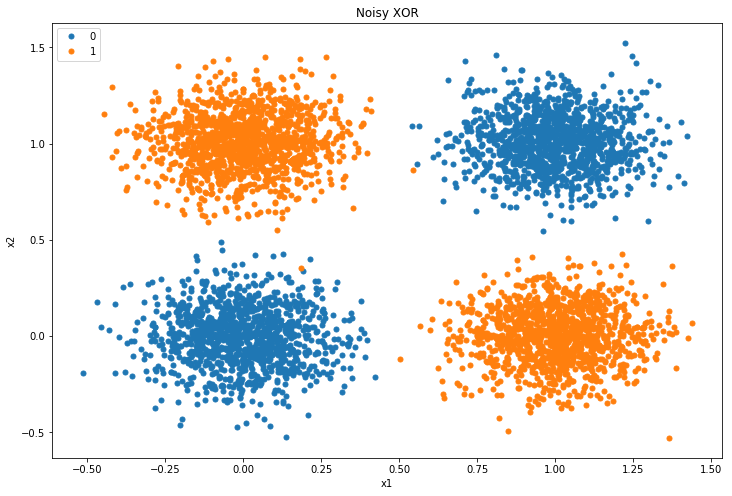

In [7]:
plot_data(X, y, 'Noisy XOR', None, None)

Now let's create functions for forward and backward prop through the layers and we are off...

### a) Implement each layer of the network as a separate function with both forward propagation and backpropagation.

Define needed functions

In [8]:
# Initialize network weights by using standard normal distribution 
def init_weights(n_features, n_hiddens):
    return {
        'w_hidden': np.random.randn(n_features, n_hiddens),
        'w_output': np.random.randn(n_hiddens, n_classes)
    }

# ReLU activation function for hidden layer
def apply_activation(input_vec, activation_type):
    if activation_type == 'linear':
        pass
    elif activation_type == 'relu':
        input_vec[input_vec < 0] = 0
    
    return input_vec

# Softplus loss for output layer
def apply_loss(input_vec, loss_type):
    if loss_type == 'softmax':
        exps = np.exp(input_vec - np.max(input_vec))
        
        return exps / np.sum(exps)
    elif loss_type == 'softplus':
        return np.power(1 + np.exp(-1.0 * input_vec), -1.0)
    
    return input_vec

# Forward propagation for hidden layer
def forward_hidden(network, input_vec):
    # Supply input_vec to hidden layer
    hidden_value = input_vec @ network['w_hidden']
    
    # Apply ReLU activation
    hidden_activation = apply_activation(hidden_value, 'relu')
    
    return hidden_activation

# Forward propagation for output layer
def forward_output(network, hidden_vec, loss_type):
    # Supply hidden_vec to hidden layer
    output_value = hidden_vec @ network['w_output']
    
    # Apply Softplus/Softmax loss
    output_activation = apply_loss(output_value, loss_type)
    
    return output_activation    

# Backward propagation for both output and hidden layer
def backward(network, input_vecs, hidden_vecs, errors):
    # Errors are the gradients of the output layer, per minibatch
    dw_output = hidden_vecs.T @ errors

    # dh are the gradients of the hidden layer
    dh = errors @ network['w_output'].T
    
    dh[hidden_vecs <= 0] = 0
    
    dw_hidden = input_vecs.T @ dh

    # Return the gradients as dict and return separate avg errors/losses
    return {
        'w_hidden': dw_hidden,
        'w_output': dw_output, 
    }, np.mean(np.array(errors))

### b) Train the network using stochastic gradient descent with mini-batches.

Define needed functions

In [9]:
# For each iteration, shuffle the data before feeding it to the network
# so we don't get the same minibatches for every iteration
def shuffle(X, y):
    idxes = np.arange(X.shape[0])
    new_idxes = np.random.shuffle(idxes)
    
    return X[new_idxes][0], y[new_idxes][0]

# For each minibatch, do forward & backward propagation and compute the gradients
def get_minibatch_grad(network, X, y, loss_type):
    # Save the information in the structure below
    input_vecs, hidden_vecs, errors = [], [], []

    for x, cls_idx in zip(X, y):
        # Forward propagate
        h = forward_hidden(network, x)
        y_pred = forward_output(network, h, loss_type)

        # Create probability distribution of true label
        y_true = np.zeros(n_classes)
        y_true[int(cls_idx)] = float(1.0)

        # Compute the error between the activation and the label
        err = y_true - y_pred
        
        # Add all the info
        input_vecs.append(x)
        hidden_vecs.append(h)
        errors.append(err)

    input_vecs = np.array(input_vecs)
    hidden_vecs = np.array(hidden_vecs)
    errors = np.array(errors)
    
    # Weird bug when using 3 features for part f
    # I need to reshape below structures from (batch_size, 1, n_hiddens) to (batch_size, n_hiddens)
    if len(input_vecs.shape) == 3:
        input_vecs = input_vecs.reshape((input_vecs.shape[0], input_vecs.shape[2]))
        
    if len(hidden_vecs.shape) == 3:
        hidden_vecs = hidden_vecs.reshape((hidden_vecs.shape[0], hidden_vecs.shape[2]))
        
    if len(errors.shape) == 3:
        errors = errors.reshape((errors.shape[0], errors.shape[2]))
    
    # Backprop using the saved info
    return backward(network, np.array(input_vecs), np.array(hidden_vecs), np.array(errors))

# One step of SGD, i.e. computing gradient and updating weights for one minibatch
def do_sgd_step(network, X, y, learning_rate, loss_type):
    # Fetch minibatch grad
    grad, avg_errors_per_batch = get_minibatch_grad(network, X, y, loss_type)
    network = network.copy()

    # Update every params, w_hidden and w_output, using the grad
    for layer_weights in grad:
        network[layer_weights] = network[layer_weights] + learning_rate * grad[layer_weights]

    return network, avg_errors_per_batch

# Learning iterations
def do_sgd(network, X, y, minibatch_size, learning_rate, n_iters, loss_type, debug):
    avg_errors = []
    
    for iter in range(n_iters):
        avg_errors_per_iter = []
        
        if debug:
            if (iter + 1) % 10 == 0:
                print('Iteration {}'.format(iter))

        # Shuffle 
        X, y = shuffle(X, y)

        # Iterate over minibatches
        for i in range(0, X.shape[0], minibatch_size):
            X_minibatch = X[i:i + minibatch_size]
            y_minibatch = y[i:i + minibatch_size]

            # Computes gradient and updates weights for one minibatch
            network, avg_errors_per_batch = do_sgd_step(network, X_minibatch, y_minibatch, learning_rate, loss_type)
            
            avg_errors_per_iter.append(avg_errors_per_batch)
            
        avg_errors.append(np.mean(avg_errors_per_iter))

    return network, np.array(avg_errors)

# Main learning routine
def train(X, y, n_features, n_classes, n_hiddens, n_iters, loss_type, learning_rate, minibatch_size, debug):
    # Initialize network
    network = init_weights(n_features, n_hiddens)
    
    # Do SGD for n_iterations
    network, errors = do_sgd(network, X, y, minibatch_size, learning_rate, n_iters, loss_type, debug)
    
    return network, errors

Make X, y as arrays and do sanity check

In [10]:
X = np.array(X)
y = np.array(y).flatten()

assert X.shape == (5000, 2)
assert y.shape == (5000,)

Train using only $2$ hidden units and `softplus` loss. Set `learning rate` to $10^{(-4)}$ and `number of iterations` to $100$. Set `minibatch size` to $32$. We'll see in part c whether or not this gives a good decision boundary.

In [11]:
n_features = 2 # (x1, x2)
n_classes = 2 # 0 or 1

n_hiddens = 2 # number of hidden units
n_iters = 100 # number of learning iteration

loss_type = 'softplus'
learning_rate = 1e-4
minibatch_size = 32

network, errors = train(X, y, n_features, n_classes, n_hiddens, n_iters, loss_type, learning_rate, minibatch_size, False)

Plot losses per epoch

In [12]:
def plot_losses(errors, title):
    n_iters = len(errors)
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    
    ax.plot(np.arange(1, n_iters + 1, 1), errors)

    ax.legend()
    ax.legend(loc=2)
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Average Losses')
    
    ax.set_title(title)
    
    plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


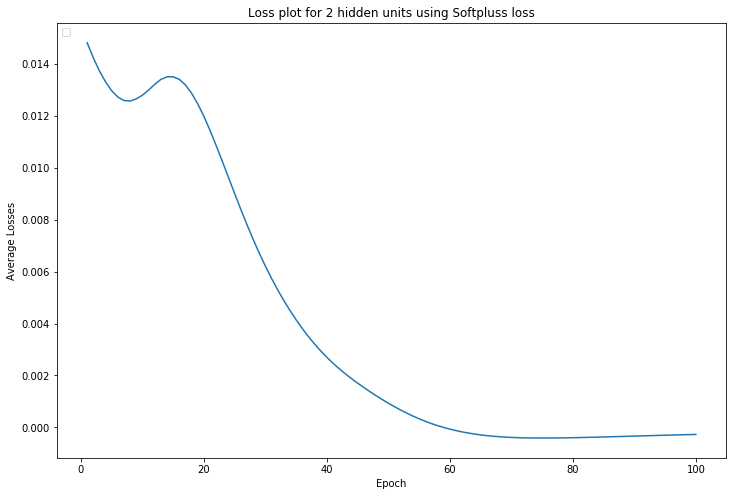

In [13]:
plot_losses(errors, 'Loss plot for 2 hidden units using Softpluss loss')

From the loss plot, we can see that the network converges

### c) Show the decision regions of the trained classifier by densely generating points in the plane and color coding these points with the binary labels.

Define needed functions

In [14]:
# Predict label y given X
def classify(network, X, loss_type):
    # Probabilities placeholder
    probs = []
    
    # Iterate for each sample 
    for _, x in enumerate(X):
        # Forward propagate to get probability distribution of label y given X
        hidden_activation = forward_hidden(network, x)
        prob = forward_output(network, hidden_activation, loss_type)
        
        probs.append(prob)
        
    # Replace NaN with 1, it is usually when the denominator is zero
    probs = np.where(probs == np.NaN, 1, probs) 
    
    # Get label by taking the argmax of the prob dist
    return np.argmax(probs, axis=2)

# Generate 2D dense data for decision boundary
# The dense samples are square in shape, so x1_low == x2_low and x1_high == x2_high
def generate_dense_data_2d(network, low, high, step, loss_type):
    # How many dots are within one line, either vertically and horizontally
    reps = int((high - low) / step) + 1
    
    # Generate different x1s using np.arange
    x1 = np.arange(low, high + step, step)
    # Repeat, so we get something like: [-0.5, -0.5, -0.5, -0.4, -0.4, -0.4, ...]
    x1 = np.repeat(x1, reps)
    
    # Generate different x2s using np.arange, but the value is actually the same as x1s
    x2 = np.arange(low, high + step, step)
    # Make a tile, so we get something like: [-0.5, -0.4, -0.3, -0.5, -0.4, -0.3, ...]
    x2 = np.tile(x2, reps)
    
    # Set a placeholder of size reps squared
    n_data = reps ** 2
    dense_data = pd.DataFrame(np.zeros((n_data, 3)), columns=['x1', 'x2', 'y'])

    # Assign x1s and x2s to the placeholder, each as separate series
    dense_data.iloc[:, 0] = x1
    dense_data.iloc[:, 1] = x2
   
    # Create np.matrix of X feature to be feed to the network
    X = np.matrix(dense_data.iloc[:, 0:2].values)

    # Get probability distribution of label y given X
    y = classify(network, X, loss_type)
    
    # Assign ys to the placeholder
    dense_data.iloc[:, 2] = y
    
    return dense_data

# Convert from DataFrame to Numpy and do sanity check
def convert_and_check_data(data, n_data, dim):
    X, y = convert_to_numpy(data)

    y_modified = y.flatten()
    y_modified = np.array(y_modified)[0]

    assert X.shape == (n_data, dim)
    assert y_modified.shape == (n_data,)
    
    return X, y_modified

# Modify plot data to enable plotting overlay
def plot_data_overlay(X, y_prob, X_dense, y_prob_dense, title, colorset):
    cx, cy, cx_dense, cy_dense = colorset[0], colorset[1], colorset[2], colorset[3]
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    
    y_predict_dense = y_prob_dense > 0.5
    indices_0_dense = [k for k in range(0, X_dense.shape[0]) if not y_predict_dense[k]]
    indices_1_dense = [k for k in range(0, X_dense.shape[0]) if y_predict_dense[k]]
    
    ax.plot(X_dense[indices_0_dense, 0], X_dense[indices_0_dense, 1], color=cx_dense, marker='o', linestyle='', ms=5)
    ax.plot(X_dense[indices_1_dense, 0], X_dense[indices_1_dense, 1], color=cy_dense, marker='o', linestyle='', ms=5)
    
    y_predict = y_prob > 0.5
    indices_0 = [k for k in range(0, X.shape[0]) if not y_predict[k]]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k]]
    
    ax.plot(X[indices_0, 0], X[indices_0, 1], color=cx, marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1, 1], color=cy, marker='o', linestyle='', ms=5, label='1')

    ax.legend()
    ax.legend(loc=2)
    
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    
    ax.set_title(title)
    plt.show()

Generate densely sampled data from the trained network

In [15]:
dense_data = generate_dense_data_2d(network, -0.5, 1.5, 1e-2, loss_type)

dense_X, dense_y = convert_and_check_data(dense_data, 40401, 2)

Finally, plot the decision boundaries against XOR data with two features. The black region is for $y=0$, meanwhile the pink region is for $y=1$.

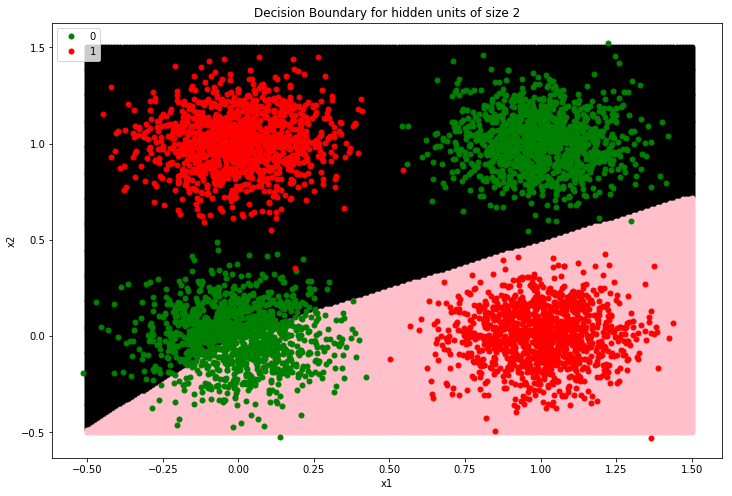

In [16]:
colorset = ['green', 'red', 'black', 'pink']

plot_data_overlay(X, y, dense_X, dense_y, 'Decision Boundary for hidden units of size 2', colorset)

We could see that 2 hidden units are clearly not sufficient. The resulting decision boundary can include all the red dots instances on the bottom right corner in the correct region (pink region), but the pink region also includes some green dots instances as well on the bottom left corner, which is basically a misclassification. The red dots instances on the top left corner are fully misclassified, i.e. they are included in the black region instead of the pink region. 

Roughly 45-50% green dots instances on the bottom left corner are misclassified by being in the wrong region (pink region). The classification for the green dots instances on the top right corner, however, is perfect.

### d) Repeat (b) and (c) varying the number of hidden units: 3, 16, 512. Discuss how the number of hidden units effects the solution.

Generate densely sampled data from the trained network with `hidden units` of size $3$. Train using `softplus` loss. Keep `learning rate` to $10^{(-3)}$ and `number of iterations` to $100$. Keep `minibatch size` to $32$.

In [17]:
n_hiddens = 3

network, errors = train(X, y, n_features, n_classes, n_hiddens, n_iters, loss_type, learning_rate, minibatch_size, False)

dense_data = generate_dense_data_2d(network, -0.5, 1.5, 1e-2, loss_type)

dense_X, dense_y = convert_and_check_data(dense_data, 40401, 2)

Plot losses per epoch

No handles with labels found to put in legend.
No handles with labels found to put in legend.


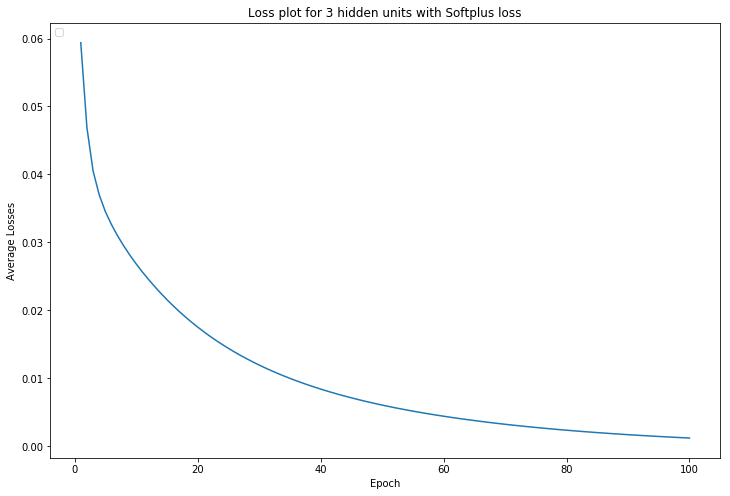

In [18]:
plot_losses(errors, 'Loss plot for 3 hidden units with Softplus loss')

We can see that the network smoothly converges

Plot the decision boundaries against XOR data with two features

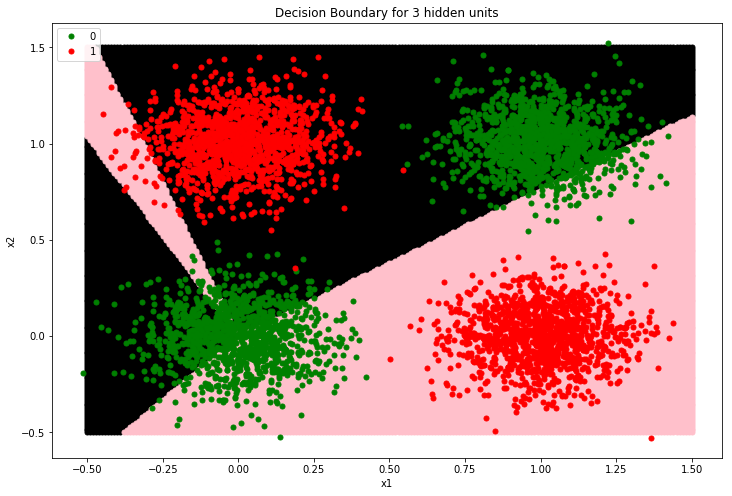

In [19]:
plot_data_overlay(X, y, dense_X, dense_y, 'Decision Boundary for 3 hidden units', colorset)

We could see that 3 hidden units are still not sufficient, but it does just a little bit better than 2 hidden units. The resulting decision boundary can separate quite well between the green dots ($y=0$) on the top right corner and the red dots ($y=1$) on the bottom right corner, although rougly 20% of the green dots instances are misclassified, which is worse than 2 hidden units actually.

The little good news is that now a small portion (~5%) of the red dots instances on the top left corner are correctly classified. The bad news though is that now the misclassification for green dots instances on the bottom left corner increases a little bit, with roughly 50-55% being in the wrong region (pink region).

Generate densely sampled data from the trained network with `hidden units` of size $16$. Train using `softplus` loss. Keep `learning rate` to $10^{(-3)}$ and `number of iterations` to $100$. Keep `minibatch size` to $32$.

In [20]:
n_hiddens = 16

network, errors = train(X, y, n_features, n_classes, n_hiddens, n_iters, loss_type, learning_rate, minibatch_size, False)

dense_data = generate_dense_data_2d(network, -0.5, 1.5, 1e-2, loss_type)

dense_X, dense_y = convert_and_check_data(dense_data, 40401, 2)

Plot losses per epoch

No handles with labels found to put in legend.
No handles with labels found to put in legend.


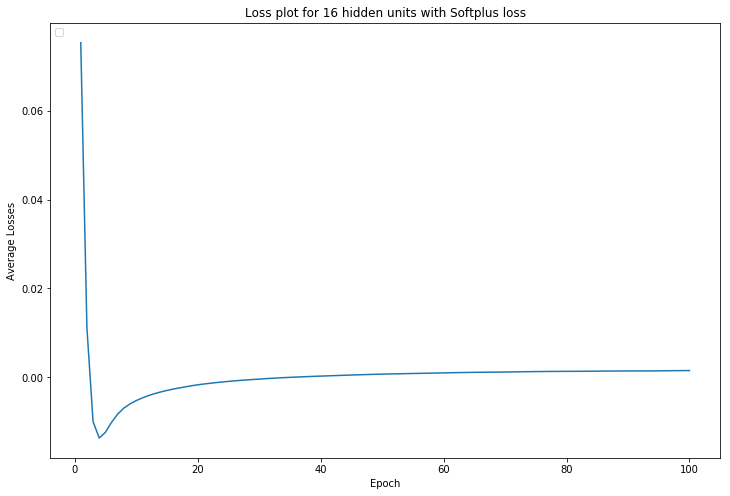

In [21]:
plot_losses(errors, 'Loss plot for 16 hidden units with Softplus loss')

We can see that the network converges very fast at the beginning and become stale afterwards

Plot the decision boundaries against XOR data with two features

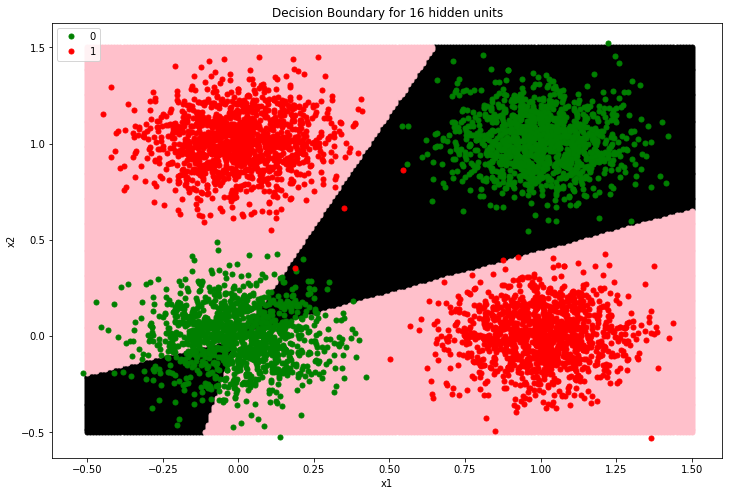

In [22]:
plot_data_overlay(X, y, dense_X, dense_y, 'Decision Boundary for 16 hidden units', colorset)

We could see that 16 hidden units, while not perfect, are quite sufficient and far better than 2 and 3 hidden units. The pink regions include almost all red dots instances, resulting in a very low misclassifiaction rate for $y=1$. The red dots outside the pink regions are possibly outliers, created by the noise.

The black regions include all green dots on the top right corner. But, it still can't include all the green dots instances on the bottom left corner, just like the 2 and 3 hidden units. Roughly 75% of those green dots are misclassified in the pink region.

Generate densely sampled data from the trained network with `hidden units` of size $512$. Train using `softplus` loss. Keep `learning rate` to $10^{(-3)}$ and `number of iterations` to $100$. Keep `minibatch size` to $32$.

In [23]:
n_hiddens = 512

network, errors = train(X, y, n_features, n_classes, n_hiddens, n_iters, loss_type, learning_rate, minibatch_size, False)

dense_data = generate_dense_data_2d(network, -0.5, 1.5, 1e-2, loss_type)

dense_X, dense_y = convert_and_check_data(dense_data, 40401, 2)

Plot losses per epoch

No handles with labels found to put in legend.
No handles with labels found to put in legend.


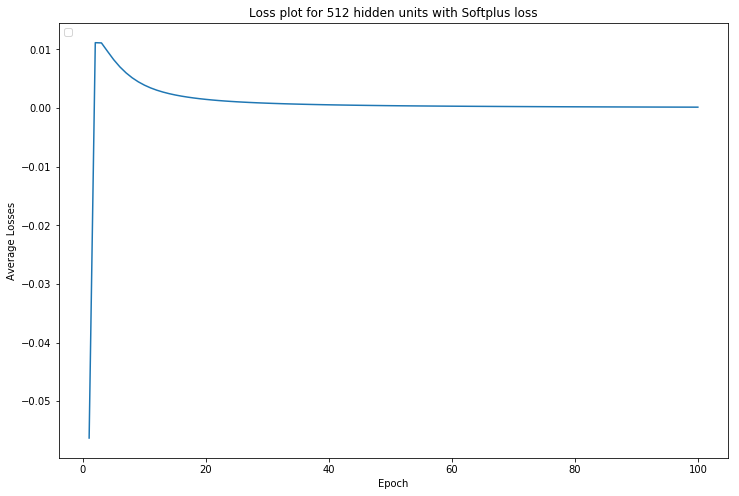

In [24]:
plot_losses(errors, 'Loss plot for 512 hidden units with Softplus loss')

The plot loss is strange, it starts with negative loss and I can't figure out why but the final loss is very small, i.e. close to zero

Plot the decision boundaries against XOR data with two features

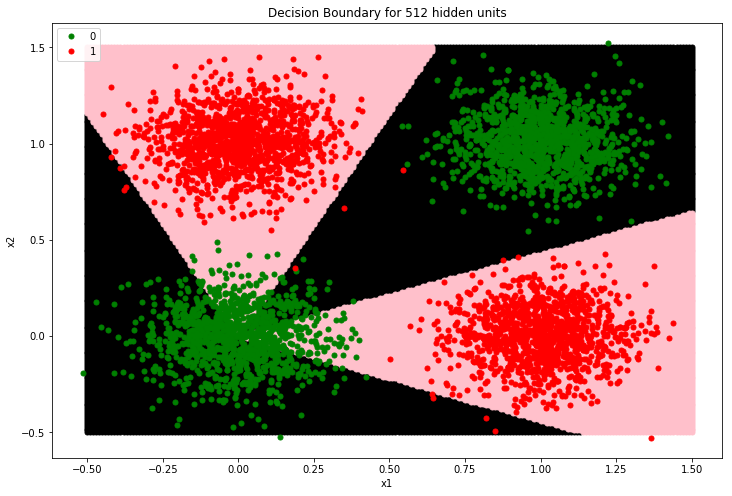

In [25]:
plot_data_overlay(X, y, dense_X, dense_y, 'Decision Boundary for 512 hidden units', colorset)

We could see that 512 hidden units are still not perfect but it performs significantly better than 16 hidden units. Just like 16 hidden units, the pink regions include almost all red dots instances. 

The black regions include all green dots on the top right corner, just like 16 hidden units. Finally, the improvemnent is that the misclassification rate for $y=0$, i.e. the green dots instances, is lower than that of 16 hidden units. Roughly only 20-25% of the green dots instances on the bottom left corner are misclassified, compared to 75% for 16 hidden units.

### e) Try choosing your own loss function (without asking me or the TAs what you should choose), repeating (d).

I choose ```softmax``` loss.

Generate densely sampled data from the trained network with `hidden units` of size $3$. Train using `softmax` loss. Keep `learning rate` to $10^{(-4)}$ and `number of iterations` to $100$. Keep `minibatch size` to $32$.

In [26]:
n_features = 2 # (x1, x2)
n_classes = 2 # 0 or 1

n_hiddens = 3 # number of hidden units
n_iters = 100 # number of learning iteration

loss_type = 'softmax'
learning_rate = 1e-4
minibatch_size = 32

network, errors = train(X, y, n_features, n_classes, n_hiddens, n_iters, loss_type, learning_rate, minibatch_size, False)

dense_data = generate_dense_data_2d(network, -0.5, 1.5, 1e-2, loss_type)

dense_X, dense_y = convert_and_check_data(dense_data, 40401, 2)

Plot the decision boundaries against XOR data with two features

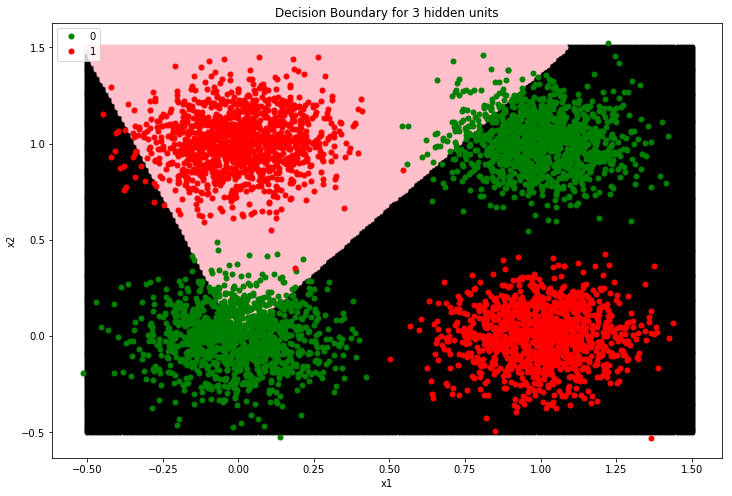

In [28]:
plot_data_overlay(X, y, dense_X, dense_y, 'Decision Boundary for 3 hidden units', colorset)

We could see that 3 hidden units with softmax loss are far from sufficient. It identifies well enough the green dots instances, with only 15-20% misclassification rate overall. But, for the green dots instances on the bottom right corner, they are fully misclassified. The other red dots instances on the top left corner are fine, however, with only small misclassification rate (less than 5%).

Generate densely sampled data from the trained network with `hidden units` of size $16$. Train using `softmax` loss. Keep `learning rate` to $10^{(-3)}$ and `number of iterations` to $100$. Keep `minibatch size` to $32$.

In [30]:
n_hiddens = 16

network, errors = train(X, y, n_features, n_classes, n_hiddens, n_iters, loss_type, learning_rate, minibatch_size, False)

dense_data = generate_dense_data_2d(network, -0.5, 1.5, 1e-2, loss_type)

dense_X, dense_y = convert_and_check_data(dense_data, 40401, 2)

Plot the decision boundaries against XOR data with two features

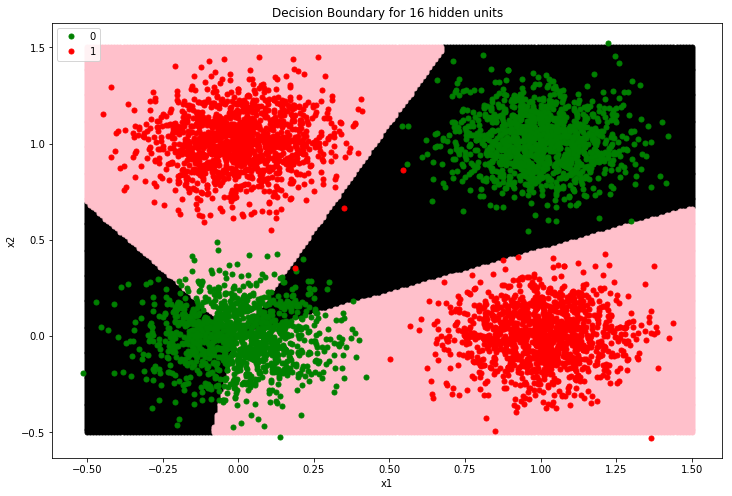

In [32]:
plot_data_overlay(X, y, dense_X, dense_y, 'Decision Boundary for 16 hidden units', colorset)

We could see that 16 hidden units with softmax loss are far from sufficient. This decision boundary closely resembles that of the 16 hidden units with softplus loss. It's just the decision boundary shape in the bottom left corner is less symmetrical than that of the 16 hidden units with softplus loss. Nevertheless, the misclassification rate for the green dots are still quite high, ~50%.

Generate densely sampled data from the trained network with `hidden units` of size $512$. Train using `softmax` loss. Keep `learning rate` to $10^{(-3)}$ and `number of iterations` to $100$. Keep `minibatch size` to $32$.

In [34]:
n_hiddens = 512

network, errors = train(X, y, n_features, n_classes, n_hiddens, n_iters, loss_type, learning_rate, minibatch_size, False)

dense_data = generate_dense_data_2d(network, -0.5, 1.5, 1e-2, loss_type)

dense_X, dense_y = convert_and_check_data(dense_data, 40401, 2)

Plot the decision boundaries against XOR data with two features

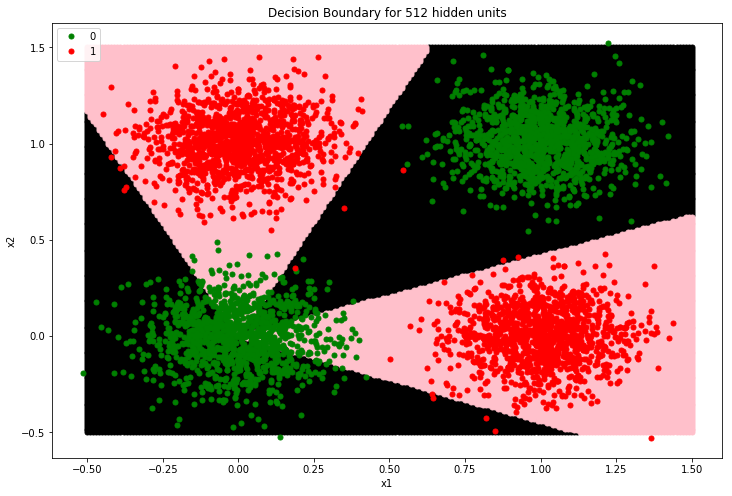

In [36]:
plot_data_overlay(X, y, dense_X, dense_y, 'Decision Boundary for 512 hidden units', colorset)

We could see that 512 hidden units with softmax loss are still not perfect but it performs much better than 16 hidden units with softmax loss. 

The resulting decision boundary is nearly the same with that of 512 hidden units with softplus loss. I don't see any major differences.

### f) Now try with three inputs, generating your own training and validation data. (For this XOR the output should be a 1 if and only if exactly one of the inputs is 1. But make the training data noisy as before.) Use softplus loss. Do not try to show the decision regions, instead generate a validation set in the same manner as the training set, classify the samples, and compute the classification accuracy.

Creating XOR data with three features

In [37]:
data = build_data(5000, 3)

data.head()

,x1,x2,x3,y
0,1.032264,1.008116,1.122041,0.0
1,-0.057321,0.742908,0.008447,1.0
2,1.033682,0.017595,-0.166691,1.0
3,0.972982,0.779643,0.563874,0.0
4,1.165243,-0.207396,-0.030632,1.0


Let's message this data into a numpy format and divide into train (0.8) and test (0.2) set

In [38]:
def split_train_test(X, y, train_ratio):
    data_len = len(X)
    idx_split = int(train_ratio * data_len)
    
    X_train = X[0:idx_split]
    y_train = y[0:idx_split]
    
    X_test = X[idx_split:data_len]
    y_test = y[idx_split:data_len]
    
    assert X_train.shape == (int(train_ratio * data_len), 3)
    assert y_train.shape == (int(train_ratio * data_len),)

    assert X_test.shape == (data_len - int(train_ratio * data_len), 3)
    assert y_test.shape == (data_len - int(train_ratio * data_len),)
    
    return X_train, y_train, X_test, y_test 

X, y = convert_and_check_data(data, 5000, 3)

X_train, y_train, X_test, y_test = split_train_test(X, y, 0.8)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(4000, 3)
(4000,)
(1000, 3)
(1000,)


Define function to compute accuracy

In [53]:
def compute_accuracy(ys, y_preds):
    verdict = np.array([1 if y == y_pred else 0 for y, y_pred in zip(ys, y_preds)])
    
    return np.sum(verdict) / len(verdict)

Call the main routine to train the network and display the validation accuracy. Train using `hidden units` of size $3$, $6$ and $512$. Use `softplus` loss. Increase `learning rate` to $10^{(-3)}$ and `number of iterations` to $100$. Keep `minibatch size` to $32$.

In [54]:
n_features = 3 # (x1, x2, x3)
n_classes = 2 # 0 or 1

n_iters = 100 # number of learning iteration

loss_type = 'softplus'
learning_rate = 1e-3
minibatch_size = 32

for n_hiddens in [3, 16, 512]:
    network, errors = train(X_train, y_train, n_features, n_classes, n_hiddens, n_iters, loss_type, learning_rate, minibatch_size, False)
    
    y_preds = classify(network, X_test, loss_type)
    
    acc = compute_accuracy(y_test, y_preds)
    
    print('Validation accuracy of network with {0} hidden units for this three features XOR data is: {1:.2f}'.format(n_hiddens, acc))

Validation accuracy of network with 3 hidden units for this three features XOR data is: 0.71
Validation accuracy of network with 16 hidden units for this three features XOR data is: 0.97
Validation accuracy of network with 512 hidden units for this three features XOR data is: 0.97


We can see that the validation accuracy jumps highly from 0.71 to 0.97 when we increase the hidden unit from 3 to 16. But, further increasing to 512 doesn't increase the validation accuracy.

### g) Using your data from HW1 or any new data you curate, train your MLP using your training set (80%). Compute the error rate on your validation set (20%). It's up to you how many hidden units to use.

#### Data Description

I use image data, taken from Google. The classes are "Central Park" and "Time Square". Each class has 120 data in total, with 96 of them being the train set and the other 24 of them being the test set.

In [55]:
!pip install matplotlib numpy opencv-python scipy 

In [56]:
!ls "data/train/centralpark" | wc -l
!ls "data/train/timesquare" | wc -l
!ls "data/test/centralpark" | wc -l
!ls "data/test/timesquare" | wc -l

      96
      96
      24
      24


#### Imports and Dir Constants

In [57]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import cv2

from scipy.stats import multivariate_normal
from datetime import datetime

base_path        = 'data'
train_path       = base_path + '/train'
test_path        = base_path + '/test'

#### Determine Fixed Size

I find that for both train and test data, there is no image with lower resolution than 200x200, so I pick that as my fixed size

In [58]:
def fetch_dim(image, label):
    height, width, channels = image.shape
    return label, height, width

def find_min_size(is_train, threshold):
    # Pick the corresponding path
    if is_train:
        print('Find in train data ...')
        data_path = train_path
    else:
        print('Find in test data ...')
        data_path = test_path

    # Get the labels, sorted, in this case it's just ['cats', 'dogs']
    classes = sorted(os.listdir(data_path))

    # Array to store image size
    image_sizes = []

    # Loop over each dir, each corresponds to a label
    for label in classes:
        # Get dir full path
        dir = os.path.join(data_path, label)
      
        if '.DS_Store' not in dir:
            # Loop over the images in the dir
            for image_file in os.listdir(dir):
                image_path = os.path.join(dir, image_file)

                # Calculate size
                if 'HEIC' not in image_path:
                    image = cv2.imread(image_path)
                    image_sizes.append(fetch_dim(image, label))

    # Return all image sizes that are less than the size threshold
    return [elem for elem in image_sizes if elem[0] == classes[0] and elem[1] < threshold and elem[2] < threshold], [elem for elem in image_sizes if elem[0] == classes[1] and elem[1] < threshold and elem[2] < threshold]

train_min_size = find_min_size(True, 200)
print(len(train_min_size[0]), len(train_min_size[1]))

test_min_size = find_min_size(False, 200)
print(len(test_min_size[0]), len(test_min_size[1]))

# Set fixed_size constant
fixed_size = tuple([200, 200])

Find in train data ...
0 0
Find in test data ...
0 0


#### Feature Extractor Function

I use Color Histogram from OpenCV as my feature, with the following detail:
1. Using three channels (RGB), denoted by [0 1 2]
2. The color range is default, 0 to 256
3. There are 8 bins (I handpick this, no particular reason).

The above scenario results in a feature vector of size 512.

In [59]:
bins = 8

# Color Histogram Feature
# a. Convert the image to HSV color-space
# b. Compute the color histogram
# c. Normalize the histogram
def compute_histogram(image, mask=None):
    hist = cv2.calcHist([cv2.cvtColor(image, cv2.COLOR_BGR2HSV)], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

#### Precompute the Features for Train and Test Data

In [60]:
image_sizes = []

def precompute_features(is_train, is_timed):
    if is_timed:
        start = datetime.now()

    # Pick the corresponding path
    if is_train:
        print('Precomputing train data features...')
        data_path = train_path
    else:
        print('Precomputing test data features...')
        data_path = test_path

    # Placeholder for returned features and labels
    features = []
    labels = []

    # Get the labels, sorted, in this case it's ['centralpark', 'timesquare']
    classes = sorted(os.listdir(data_path))
    
    # Loop over each dir, each corresponds to a label
    for label in classes:
        # Get dir full path
        dir = os.path.join(data_path, label)

        if '.DS_Store' not in dir:
            # Loop over the images in the dir
            for image_file in os.listdir(dir):
                image_path = os.path.join(dir, image_file)

                # Resize image, refer to the previous constant
                if 'HEIC' not in image_path:
                    image = cv2.imread(image_path)
                    image_sizes.append(fetch_dim(image, label))
                    image = cv2.resize(image, fixed_size)

                # Extract three different features
                hist = compute_histogram(image) 
                # print(hist.shape) #(512, )

                # Append to placeholder
                features.append(hist)
                labels.append(label)

            print("Time elapsed: {}".format(datetime.now() - start)) 
            print("Processed dir: {}".format(label))
    
    return np.array(features), labels

train_features, train_labels = precompute_features(True, True)
print('--------------------')
test_features, test_labels = precompute_features(False, True)

assert train_features.shape == (192, 512)
assert test_features.shape == (48, 512)

assert len(train_labels) == 192
assert len(test_labels) == 48
print('--------------------')

Precomputing train data features...
Time elapsed: 0:00:00.106704
Processed dir: centralpark
Time elapsed: 0:00:00.211610
Processed dir: timesquare
--------------------
Precomputing test data features...
Time elapsed: 0:00:00.023904
Processed dir: centralpark
Time elapsed: 0:00:00.050172
Processed dir: timesquare
--------------------


Convert the 512 sized vector into a vector of size 2 using the method I've mentioned before.

In [61]:
feature_dim = len(train_features[0])

assert feature_dim == 512

# Take the features from the train set
train_hist_1 = train_features[:, 0:(feature_dim//2)]
train_hist_2 = train_features[:, (feature_dim//2):feature_dim]

assert train_hist_1.shape == (192, 256)
assert train_hist_2.shape == (192, 256)

# Take the average of those features
train_avg_hist_1 = train_hist_1.mean(axis=1)
train_avg_hist_2 = train_hist_2.mean(axis=1)

assert train_avg_hist_1.shape == (192,)
assert train_avg_hist_2.shape == (192,)

# Take the features from the test set
test_hist_1 = test_features[:, 0:(feature_dim//2)]
test_hist_2 = test_features[:, (feature_dim//2):feature_dim]

assert test_hist_1.shape == (48, 256)
assert test_hist_2.shape == (48, 256)

# Take the average of those features
test_avg_hist_1 = test_hist_1.mean(axis=1)
test_avg_hist_2 = test_hist_2.mean(axis=1)

assert test_avg_hist_1.shape == (48,)
assert test_avg_hist_2.shape == (48,)

Prepare X and y to be training ready

In [62]:
# Zip the two train_avg_hist features to build X
X_train_image = np.dstack((train_avg_hist_1, train_avg_hist_2))[0]
X_test_image = np.dstack((test_avg_hist_1, test_avg_hist_2))[0]

# Convert string label to numeric, 'centralpark' as 0 and 'timesquare' as 1
y_train_image = np.array([0.0 if label == 'centralpark' else 1.0 for label in train_labels])
y_test_image = np.array([0.0 if label == 'centralpark' else 1.0 for label in test_labels])

assert X_train_image.shape == (192, 2)
assert X_test_image.shape == (48, 2)

assert y_train_image.shape == (192,) 
assert y_test_image.shape == (48,)

Train using $512$ hidden units and `softplus` loss. Increase `learning rate` to $10^{(-3)}$ and `number of iterations` to $1000$. Keep `minibatch size` to $32$.

In [63]:
n_features = 2 # (train_avg_hist_1, train_avg_hist_2)
n_classes = 2 # timesquare or centralpark

n_hiddens = 512 # number of hidden units
n_iters = 1000 # number of learning iteration

loss_type = 'softplus'
learning_rate = 1e-3
minibatch_size = 32

network, errors = train(X_train_image, y_train_image, n_features, n_classes, n_hiddens, n_iters, loss_type, learning_rate, minibatch_size, False)

Plot losses per epoch

No handles with labels found to put in legend.
No handles with labels found to put in legend.


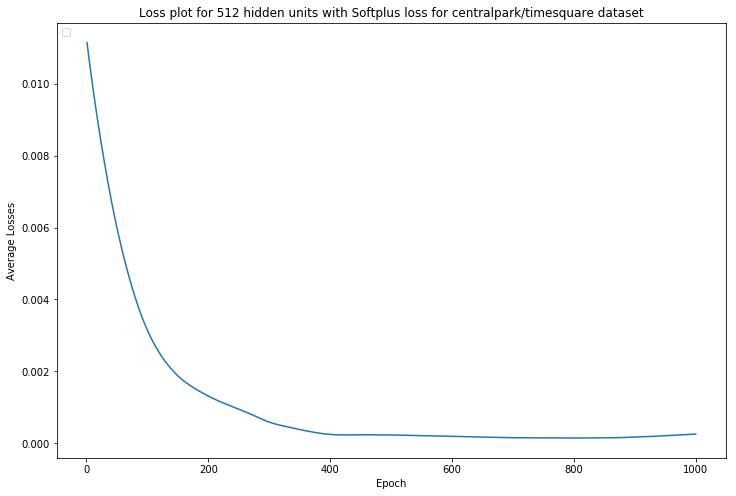

In [64]:
plot_losses(errors, 'Loss plot for 512 hidden units with Softplus loss for centralpark/timesquare dataset')

Classify test/validation images

In [65]:
# Predict label y given X
def classify_image(network, X, loss_type):
    # Probabilities placeholder
    probs = []
    
    # Iterate for each sample 
    for _, x in enumerate(X):
        # Forward propagate to get probability distribution of label y given X
        hidden_activation = forward_hidden(network, x)
        prob = forward_output(network, hidden_activation, loss_type)
        
        probs.append(prob)
        
    # Replace NaN with 1, it is usually when the denominator is zero
    probs = np.where(probs == np.NaN, 1, probs) 
    
    # Get label by taking the argmax of the prob dist
    return np.argmax(probs, axis=1)

y_preds = classify_image(network, X_test_image, loss_type)

# Some sanity check
assert len(y_preds) == 48
assert 0.0 in y_preds and 1.0 in y_preds # Make sure the model outputs both labels

Finally, compute the validation accuracy

In [66]:
acc = compute_accuracy(y_test_image, y_preds)
print('Validation accuracy of my MLP for this centralpark/timesquare image classification data is: {0:.2f}'.format(acc))

Validation accuracy of my MLP for this centralpark/timesquare image classification data is: 0.83
